# **Human Exploration Rover Challenge (HERC)**


## **IEEE ESPRIT SB TEAM**  
 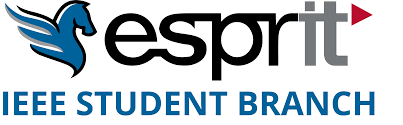

# TTS Training


In this notebook, we will:

1. Download data and format it for  TTS.
2. Configure the training and testing runs.
3. Train a new model.
4. Test the model and display its performance.

In [ ]:
! pip install -U pip
! pip install TTS

## ✅ Data Preparation

### **First things first**: we need some data.

We're training a Text-to-Speech model, so we need some _text_ and we need some _speech_. Specificially, we want _transcribed speech_. The speech must be divided into audio clips and each clip needs transcription. 

The data format we will be adopting for this tutorial is taken from the widely-used  **LJSpeech** dataset, where **waves** are collected under a folder:

<span style="color:purple;font-size:15px">
/wavs<br />
 &emsp;| - audio1.wav<br />
 &emsp;| - audio2.wav<br />
 &emsp;| - audio3.wav<br />
  ...<br />
</span>

and a **metadata.csv** file will have the audio file name in parallel to the transcript, delimited by `|`:

<span style="color:purple;font-size:15px">
# metadata.csv <br />
audio1|This is my sentence. <br />
audio2|This is maybe my sentence. <br />
audio3|This is certainly my sentence. <br />
audio4|Let this be your sentence. <br />
...
</span>

In the end, we should have the following **folder structure**:

<span style="color:purple;font-size:15px">
/MyTTSDataset <br />
&emsp;| <br />
&emsp;| -> metadata.csv<br />
&emsp;| -> /wavs<br />
&emsp;&emsp;| -> audio1.wav<br />
&emsp;&emsp;| -> audio2.wav<br />
&emsp;&emsp;| ...<br />
</span>

## Dataset


In [ ]:
import os

# BaseDatasetConfig: defines name, formatter and path of the dataset.
from TTS.tts.configs.shared_configs import BaseDatasetConfig

output_path = "tts_train_dir"

if not os.path.exists(output_path):
    os.makedirs(output_path)
!tar -bz2 tts_train_dir/LJSpeech-1.1.tar.bz2 

In [ ]:
dataset_config = BaseDatasetConfig(
    formatter="ljspeech", meta_file_train="metadata.csv", path=os.path.join(output_path, "LJSpeech-1.1/")
)

## ✅ Training
we will be using `GlowTTS`.

We will begin by initializing the model training configuration.

In [ ]:
# GlowTTSConfig: all model related values for training, validating and testing.
from TTS.tts.configs.glow_tts_config import GlowTTSConfig
config = GlowTTSConfig(
    batch_size=32,
    eval_batch_size=16,
    num_loader_workers=4,
    num_eval_loader_workers=4,
    run_eval=True,
    test_delay_epochs=-1,
    epochs=100,
    text_cleaner="phoneme_cleaners",
    use_phonemes=True,
    phoneme_language="en-us",
    phoneme_cache_path=os.path.join(output_path, "phoneme_cache"),
    print_step=25,
    print_eval=False,
    mixed_precision=True,
    output_path=output_path,
    datasets=[dataset_config],
    save_step=1000,
)

Next we will initialize the audio processor which is used for feature extraction and audio I/O.

In [ ]:
from TTS.utils.audio import AudioProcessor
ap = AudioProcessor.init_from_config(config)
# Modify sample rate if for a custom audio dataset:
# ap.sample_rate = 22050


Next we will initialize the tokenizer which is used to convert text to sequences of token IDs.  If characters are not defined in the config, default characters are passed to the config.

In [ ]:
from TTS.tts.utils.text.tokenizer import TTSTokenizer
tokenizer, config = TTSTokenizer.init_from_config(config)

Next we will load data samples. Each sample is a list of ```[text, audio_file_path, speaker_name]```. You can define your custom sample loader returning the list of samples.

In [ ]:
from TTS.tts.datasets import load_tts_samples
train_samples, eval_samples = load_tts_samples(
    dataset_config,
    eval_split=True,
    eval_split_max_size=config.eval_split_max_size,
    eval_split_size=config.eval_split_size,
)

Now we're ready to initialize the model.

Models take a config object and a speaker manager as input. Config defines the details of the model like the number of layers, the size of the embedding, etc. Speaker manager is used by multi-speaker models.

In [ ]:
from TTS.tts.models.glow_tts import GlowTTS
model = GlowTTS(config, ap, tokenizer, speaker_manager=None)

Trainer provides a generic API to train all the TTS models with all its perks like mixed-precision training, distributed training, etc.

In [ ]:
from trainer import Trainer, TrainerArgs
trainer = Trainer(
    TrainerArgs(), config, output_path, model=model, train_samples=train_samples, eval_samples=eval_samples
)

In [ ]:
trainer.fit()

#### 🚀 Run the Tensorboard. 🚀
On the notebook and Tensorboard, you can monitor the progress of your model. Also Tensorboard provides certain figures and sample outputs.

In [ ]:
!pip install tensorboard
!tensorboard --logdir=tts_train_dir

## ✅ Test the model

Let's get the latest saved checkpoint.

In [ ]:
import glob, os
output_path = "tts_train_dir"
ckpts = sorted([f for f in glob.glob(output_path+"/*/*.pth")])
configs = sorted([f for f in glob.glob(output_path+"/*/*.json")])

In [ ]:
 !tts --text "Text for TTS" \
      --model_path $test_ckpt \
      --config_path $test_config \
      --out_path out.wav

In [ ]:
import IPython
IPython.display.Audio("out.wav")